In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy as cp
import h5py
import sys
import corner
import copy
import scipy

from mpl_toolkits.mplot3d import Axes3D
from scipy.special import comb
from astropy import units as u

import analysis
import signals
import estimators
import fitting
import models
import utils
import survey
import visualizations as vis

In [3]:
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

/var/folders/6p/02rmzl7n1kj6rmdqv5rgb9xh0000gn/T/ipykernel_86514/2856889341.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [4]:
colors.to_rgb(palette[0])

(0.0, 0.4470588235294118, 0.6980392156862745)

# Simulations

In [5]:
rez = 512 # 1024
#box = h5py.File('halos.z8.hdf5', 'r')
box_old = h5py.File('L80_halos_z=6.0155.hdf5', 'r')

In [6]:
box_old.keys()

<KeysViewHDF5 ['mass', 'pos', 'rho']>

In [7]:
redshift_small = 6.0155
redshift_large = 7.9589

In [8]:
#density_big = np.fromfile('rho.z=07.9589_cic_1024', dtype=np.float64).reshape(rez, rez, rez, order='F')

In [9]:
#density_big.max()

In [10]:
redshift = 6.0155 #7.9589
masses = np.array(box_old[('mass')])
pos = np.array(box_old[('pos')])
density = np.array(box_old[('rho')])
x, y, z = pos.T
coords = [*pos.T]

#x = np.array(box[('x')])
#y = np.array(box[('y')])
#z = np.array(box[('z')])

In [11]:
runs = 3
n_bins = 20

In [12]:
box_size = 80 # in Mpc
r = np.linspace(0, box_size, rez)
r_vec = np.stack((r, r, r))

In [13]:
mass_voxels, mass_edges = np.histogramdd([x,y,z], bins=rez,
                                                weights=masses)

Text(0, 0.5, '$\\frac{dN}{dLog(M)}$')

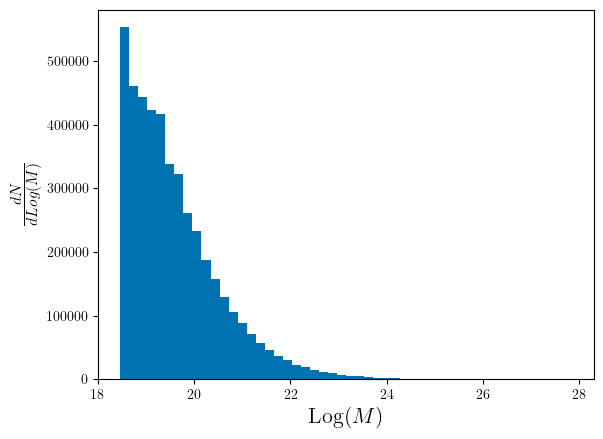

In [14]:
masses_hist = plt.hist(np.log(masses), bins=50)
plt.xlabel(r'Log$(M)$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dLog(M)}$', fontsize=16)

In [15]:
delta = utils.overdensity(density)

/var/folders/6p/02rmzl7n1kj6rmdqv5rgb9xh0000gn/T/ipykernel_86514/2327724634.py:7: RuntimeWarning: divide by zero encountered in log10
  mass_field = ax[1].imshow(np.log10(mass_voxels.sum(axis=2)), origin='lower', extent=extents)


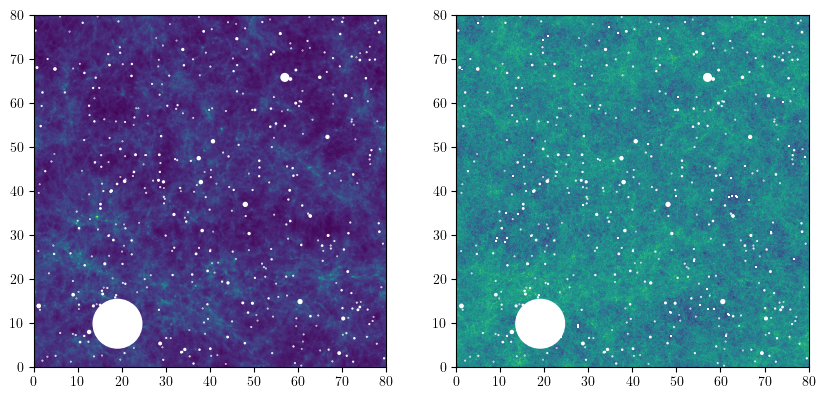

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

extents = [0,box_size,0,box_size]

#density_field = ax[0].imshow(np.log10(density.sum(axis=2)), origin='lower', extent=extents)
delta_field = ax[0].imshow(delta.sum(axis=2), origin='lower', extent=extents)
mass_field = ax[1].imshow(np.log10(mass_voxels.sum(axis=2)), origin='lower', extent=extents)

ax[0].scatter(x[0:-1:10000], y[0:-1:10000], s=1e-9 * masses[0:-1:10000], c='white')
ax[1].scatter(x[0:-1:10000], y[0:-1:10000], s=1e-9 * masses[0:-1:10000], c='white')

#fig.colorbar(density_field, ax=ax)

In [17]:
# k, P_m = analysis.calc_pspec(r_vec, [delta], n_bins=n_bins, bin_scale='log')

In [18]:
#np.savez('matter_pspec_6.0155', k=k, P_m=P_m)

In [21]:
matter_pspec_6 = np.load('spectra/matter_pspec_z6.0155.npz')
matter_pspec_7 = np.load('spectra/matter_pspec_7.9589.npz')

In [22]:
matter_pspec_6.files

['k', 'P_m']

In [23]:
k = matter_pspec_6['k']
P_m = matter_pspec_6['P_m']

In [22]:
k_HERA = np.asarray([0.18044216454909287, 0.2408186629654546, 0.30023739876976524, 0.36119894976510153,
                     0.4206720539602043, 0.4820572196322361, 0.541754861126056, 0.6029505423495476,
                     0.6624098176679414, 0.7206866526726446, 0.7815517618989362])
P_HERA = np.asarray([26.258064516129032, 27.419354838709676, 27.677419354838708, 27.741935483870968,
                     27.483870967741936, 27.29032258064516, 26.838709677419356, 26.387096774193548, 26,
                     25.548387096774192, 25.419354838709676])
SNR_HERA = np.asarray([14.0, 19.3, 18.3, 15.5, 11.8, 8.7, 6.4, 4.7, 3.6, 2.7, 2.2])

In [23]:
np.savez('HERA_noise_specs', k=k_HERA, P=P_HERA, SNR=SNR_HERA)

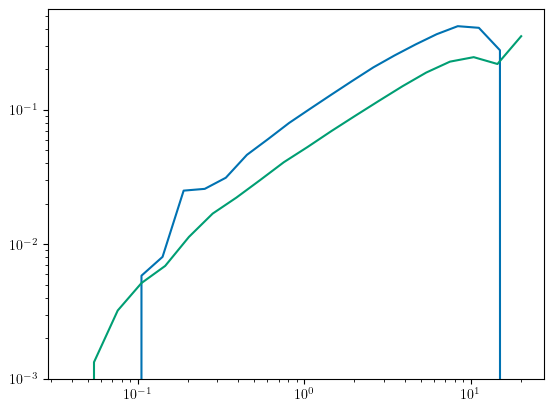

In [24]:
plt.loglog(matter_pspec_6['k'], matter_pspec_6['k']**3 / (2 * np.pi**2) * matter_pspec_6['P_m'])
plt.loglog(matter_pspec_7['k'], matter_pspec_7['k']**3 / (2 * np.pi**2) * matter_pspec_7['P_m'])

In [25]:
from scipy.interpolate import interp1d

In [26]:
P_interp = interp1d(k_HERA, P_HERA, kind='cubic')
SNR_interp = interp1d(k_HERA, SNR_HERA, kind='cubic')

In [27]:
mask = np.where((matter_pspec_6['k'] >= k_HERA[0]) & (matter_pspec_6['k'] <= k_HERA[-1]))

In [28]:
matter_pspec_6['k'][mask], k_HERA

(array([0.18839523, 0.25219119, 0.33759028, 0.45190791, 0.60493672]),
 array([0.18044216, 0.24081866, 0.3002374 , 0.36119895, 0.42067205,
        0.48205722, 0.54175486, 0.60295054, 0.66240982, 0.72068665,
        0.78155176]))

(10.0, 40.0)

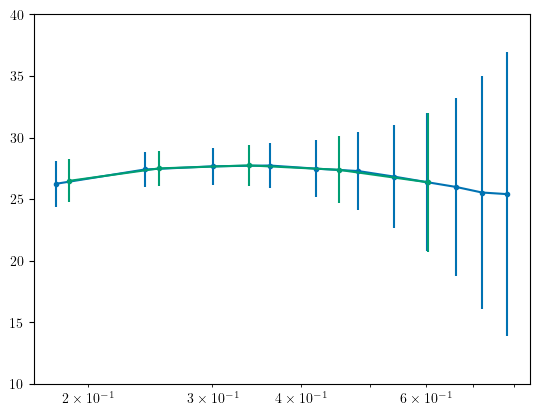

In [29]:
plt.errorbar(k_HERA, P_HERA, marker='.', yerr=P_HERA / SNR_HERA)
plt.errorbar(matter_pspec_6['k'][mask], P_interp(matter_pspec_6['k'][mask]), marker='.',
             yerr=P_interp(matter_pspec_6['k'][mask]) / SNR_interp(matter_pspec_6['k'][mask]))
plt.xscale('log')

plt.ylim(10,40)

In [30]:
matter_pspec_7['k'].min() / matter_pspec_6['k'].min()

0.4999999999999999

### Checking power spectrum code with Powerbox

Let's check our power spectrum code to make sure it does what we expect. We'll compare it to the inimitable Steven Murray's Powerbox code.

In [31]:
from powerbox import get_power

p_k_field, bins_field = get_power(delta, box_size,
                                    bins=k, bin_ave=False,
                                    vol_normalised_power=True)

In [32]:
p_k_field_log, bins_field_log = get_power(delta, box_size, log_bins=True, bin_ave=False,
                                    vol_normalised_power=True)

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:106: UserWarning: One or more radial bins had no cells within it.
  warnings.warn("One or more radial bins had no cells within it.")
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:160: RuntimeWarning: invalid value encountered in true_divide
  rl = np.bincount(indx, weights=np.real(field.flatten()), minlength=len(sumweights)+2)[1:-1] / sumweights


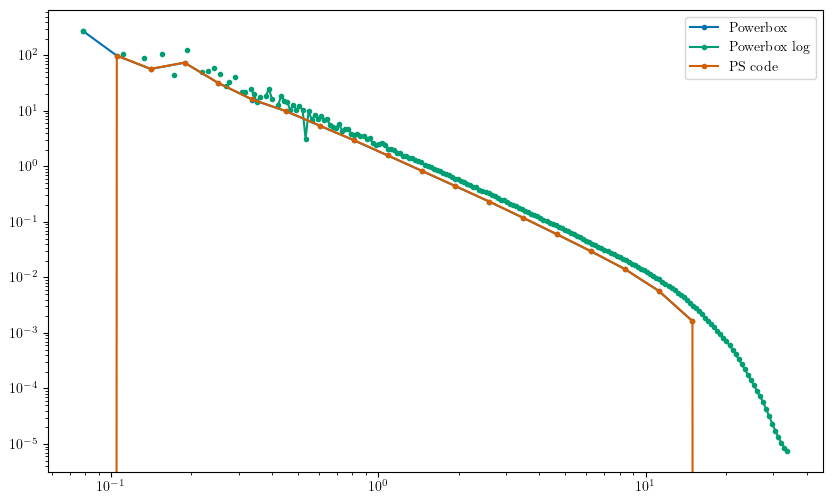

In [33]:
fig = plt.subplots(figsize=(10,6))

plt.plot(bins_field[:-1], p_k_field,label="Powerbox", marker='.')
plt.plot(bins_field_log[:-1], p_k_field_log, label="Powerbox log", marker='.', ls='-')
plt.plot(k, P_m,label="PS code", marker='.')

plt.legend()
plt.xscale('log')
plt.yscale('log')

So our power spectra code is in good agreement with Steven Murray.  A reassuring sign!

### Comparison with CAMB and Powerbox

Now we need to make sure that our spectra our reasonable, compared to known results. Let's compare with the CAMB simulation code.

In [34]:
import sys, platform, os
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/camb


In [35]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);


In [36]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[6.0155], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, redshifts, pk = results.get_matter_power_spectrum(minkh=bins_field[0], maxkh=bins_field[-5],
                                              npoints=200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=bins_field[0],
                                                                   maxkh=bins_field[-5],
                                                                   npoints = 200)


In [37]:
#calculate results for these parameters
results = camb.get_results(pars)

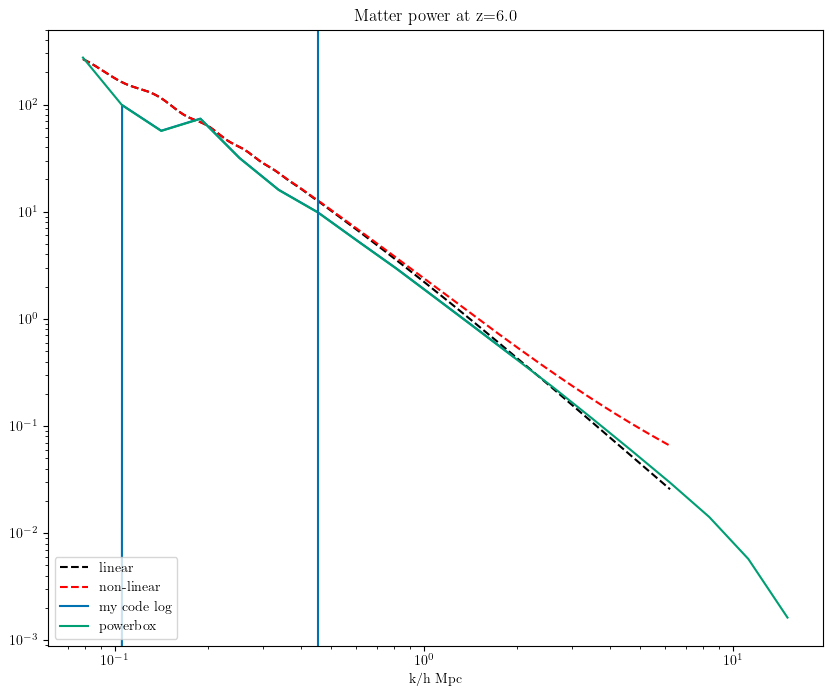

In [38]:
#for i, (redshift, line) in enumerate(zip(redshift,['-','--'])):
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(10)

plt.loglog(kh, pk[0,:], color='k', ls='--')
plt.loglog(kh_nonlin, pk_nonlin[0,:], color='r', ls='--')
    
#plt.loglog(k_log, density_pspec_log)
plt.loglog(k[0:12], P_m[0:12])
plt.loglog(bins_field[:-1], p_k_field)

plt.xlabel('k/h Mpc');
plt.legend(['linear','non-linear', 'my code log', 'powerbox'], loc='lower left');
plt.title('Matter power at z=6.0')

plt.axvline(k[6])

### Simulating the 21cm brightness temperature field

We also want to cross-correlate our intensities with the 21cm field.  In order to simulate it, we use Paul La Plante's 'quick and dirty' simulation code package <\code zreion>.

In [39]:
from zreion import apply_zreion_fast
from astropy.cosmology import Planck18

In [40]:
# parameters
#box = 80.0  # Mpc/h
omegam = Planck18.Om0
omegab = Planck18.Ob0
hubble0 = Planck18.h

alpha = 0.564
k_0 = 0.185 # Mpc/h
b_0 = 1.0 / 1.686

# global temperature as a function of redshift
def t0(redshift):
    return 38.6 * hubble0 * (omegab / 0.045) * np.sqrt(0.27 / omegam * (1 + redshift) / 10)

In [41]:
def gen_21cm_fields(delta, box_size= 80.0, zmean=7, alpha=0.11, k0=0.05):
    # compute zreion field
    print("computing zreion...")
    zreion = apply_zreion_fast(delta, zmean, alpha, k0, box_size, deconvolve=False)
    
    return zreion

def get_21cm_fields(redshift, zreion, delta):
    #print("computing t21 at z=", redshift, "...")
    ion_field = np.where(zreion > redshift, 1.0, 0.0)
    t21_field = t0(redshift) * (1 + delta) * (1 - ion_field)
    
    return ion_field, t21_field

In [42]:
Planck18.comoving_distance(7) * (100 * u.degree).to(u.radian)

<Quantity 15379.07481142 Mpc rad>

In [43]:
#zreion = gen_21cm_fields(delta)

In [44]:
#np.save('zreion', zreion)

In [45]:
t0(redshift)

22.228263183195573

In [46]:
zreion = np.load('zreion_files/zreion_z6.0155.npy') #np.load('zreion_z7.9589.npy')

In [47]:
ion_field, t21_field = get_21cm_fields(redshift, zreion, delta)

In [48]:
#zreion1 = gen_21cm_fields(delta, alpha = 0.05, k0 = 0.3)
#zreion2 = gen_21cm_fields(delta, alpha = 0.11, k0 = 0.05)
#zreion3 = gen_21cm_fields(delta, alpha = 0.15, k0 = 0.1)
#zreion4 = gen_21cm_fields(delta, alpha = 0.25, k0 = 0.07)
#zreion5 = gen_21cm_fields(delta, alpha = alpha, k0 = k_0)

In [49]:
#redshifts = np.linspace(5,15)

#def create_reion_history(redshifts, zreion, delta):
#    neutral_frac = np.zeros_like(redshifts)
#    for i, z in enumerate(redshifts):
#        ion_field, t21_field = get_21cm_fields(z, zreion, delta)
#        ion_frac = ion_field.sum() / 512**3
#        neutral_frac[i] = 1 - ion_frac
        
#    return neutral_frac

In [50]:
#neutral_frac1 = create_reion_history(redshifts, zreion1, delta)
#neutral_frac2 = create_reion_history(redshifts, zreion2, delta)
#neutral_frac3 = create_reion_history(redshifts, zreion3, delta)
#neutral_frac4 = create_reion_history(redshifts, zreion4, delta)
#neutral_frac5 = create_reion_history(redshifts, zreion5, delta)

In [51]:
#fig = plt.figure(figsize=(10,8))

#plt.plot(redshifts, neutral_frac1, label='1')
#plt.plot(redshifts, neutral_frac2, label='Paul')
#plt.plot(redshifts, neutral_frac3, label='3')
#plt.plot(redshifts, neutral_frac4, label='4')
#plt.plot(redshifts, neutral_frac5, label='Battaglia')

#plt.axhline(.5, color='gray', ls='--')
#plt.axvline(7, color='gray', ls='--')
#plt.axvline(10, color='gray', ls='--')

#plt.xlabel('redshift', fontsize=16)
#plt.ylabel('neutral fraction', fontsize=16)

#plt.legend()

In [52]:
#redshifts = np.linspace(5,15)

#neutral_frac = np.zeros_like(redshifts)

#for i, z in enumerate(redshifts):
#    ion_field, t21_field = get_21cm_fields(z, zreion, delta)
#    ion_frac = ion_field.sum() / 512**3
#    neutral_frac[i] = 1 - ion_frac

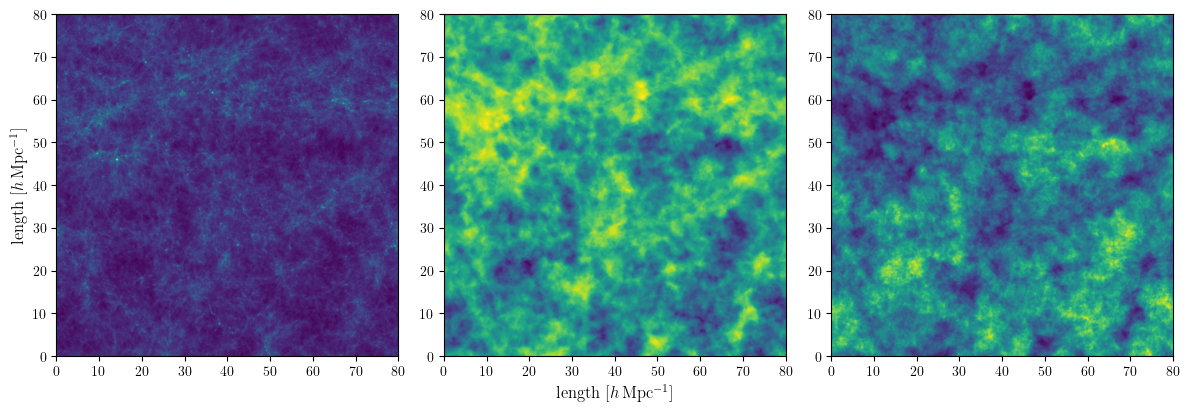

In [53]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,3, figsize=(12,8))

ax[0].imshow(delta.sum(axis=2), extent=(0,80,0,80))
ax[1].imshow(ion_field.sum(axis=2), extent=(0,80,0,80))
ax[2].imshow(t21_field.sum(axis=2), extent=(0,80,0,80))

ax[1].set_xlabel(r'length [$h$\,Mpc$^{-1}$]', fontsize=12)
ax[0].set_ylabel(r'length [$h$\,Mpc$^{-1}$]', fontsize=12)

plt.tight_layout()

Text(0, 0.5, 'length [$h$\\,Mpc$^{-1}$]')

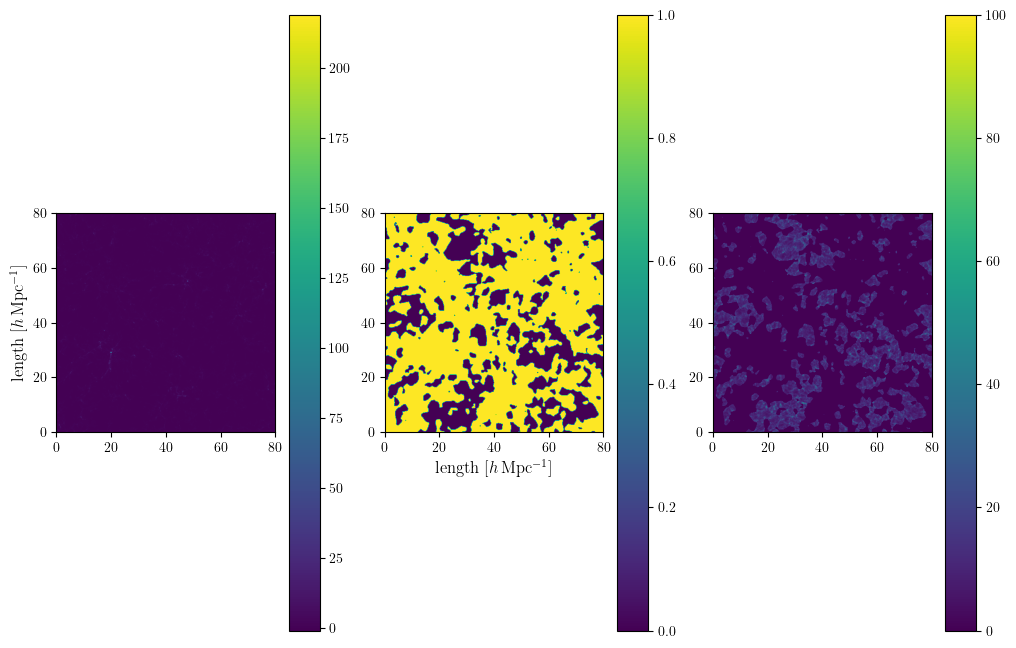

In [54]:
fig, ax = plt.subplots(1,3, figsize=(12,8))

cb1 = ax[0].imshow(delta[0,:,:], extent=(0,80,0,80))
cb2 = ax[1].imshow(ion_field[0,:,:], extent=(0,80,0,80))
cb3 = ax[2].imshow(t21_field[0,:,:], extent=(0,80,0,80), vmin=0, vmax=100)

fig.colorbar(cb1, ax=ax[0])
fig.colorbar(cb2, ax=ax[1])
fig.colorbar(cb3, ax=ax[2])

ax[1].set_xlabel(r'length [$h$\,Mpc$^{-1}$]', fontsize=12)
ax[0].set_ylabel(r'length [$h$\,Mpc$^{-1}$]', fontsize=12)


### Checking normalisation of luminosity functions 

Next we are going to need to generate some simulated specific intensities from our box our halos. This is done by 'painting' a luminosity onto the halos using a power law prescription,

$$
L(M) = L_0 \left( \frac{M}{M_0} \right)^{\alpha}
$$

Let's plot this relation for our collection our halos,

In [55]:
import astropy.constants as const

In [56]:
H_I_power = 1.3

L = 2.0 / 3.0
M = 1.0
H = 4.0 / 3.0

power_indices = [H_I_power, L, M]

L_solar=3.828e26
L_CII = 10e6
L_OIII = 10e9

luminosities_L = utils.mass2luminosity(masses, power=L)
luminosities_M = utils.mass2luminosity(masses, power=M)
luminosities_H = utils.mass2luminosity(masses, power=H)

intensities_L = utils.specific_intensity(redshift, L=luminosities_L)
intensities_M = utils.specific_intensity(redshift, L=luminosities_M)
intensities_H = utils.specific_intensity(redshift, L=luminosities_H)

Text(0, 0.5, 'luminosities')

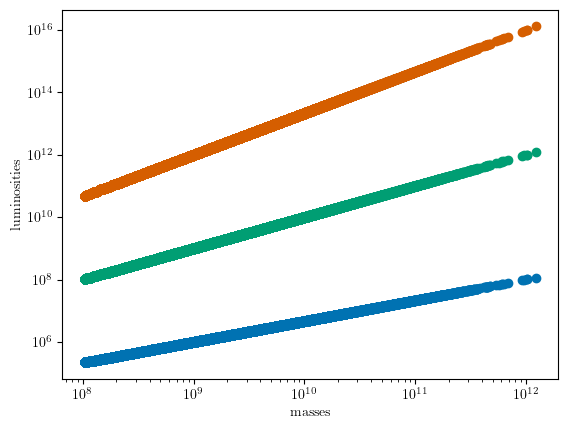

In [57]:
fig, ax = plt.subplots()

ax.scatter(masses, luminosities_L)
ax.scatter(masses, luminosities_M)
ax.scatter(masses, luminosities_H)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('masses')
ax.set_ylabel('luminosities')

In [58]:
np.mean(intensities_L), np.mean(intensities_M), np.mean(intensities_H)

(<Quantity 0.34933263 Jy / sr>,
 <Quantity 386.96156576 Jy / sr>,
 <Quantity 628221.22734607 Jy / sr>)

#### Checking unit conversion

Intensities are often given in units of Janskies.  Let's make sure that we are converting correctly from one to the other, and they are comparable to the Lidz and Beane result (https://arxiv.org/pdf/1806.02796.pdf)

In [59]:
print('Lidz: ', 3.1e2,
      ' My code: ', utils.specific_intensity(9.41))
print('Lidz: ', 7.1e2,
      ' My code: ', utils.specific_intensity(7.37))
print('Lidz: ', 1.1e3,
      'My code: ', utils.specific_intensity(6.43))

Lidz:  310.0  My code:  296.85416094619967 Jy / sr
Lidz:  710.0  My code:  675.7372227764706 Jy / sr
Lidz:  1100.0 My code:  1065.0564106095567 Jy / sr


In [60]:
def gen_spectra(fields): 

    lines_indices = np.zeros((int(comb(runs, 2) + runs), 2))
    pspecs = np.zeros((int(comb(runs, 2) + runs), n_bins))
    pspecs_dim = np.zeros((int(comb(runs, 2) + runs), n_bins))
    
    counter = 0
    for i in range(runs):
        for j in range(i, runs):
            print('Calculating correlation for Lines', i, ' and ', j)
            print('with power indices')
            k, pspec, pspec_dim = analysis.pspec(r_vec,
                            [fields[i], fields[j]],
                            n_bins=n_bins, bin_scale='log')

            pspecs[counter] = pspec
            pspecs_dim[counter] = pspec_dim

            lines_indices[counter,0] = i 
            lines_indices[counter,1] = j

            counter += 1
            
    return k, pspecs, pspecs_dim

In [38]:
indices = utils.lines_indices()
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [62]:
# shot_0 = 80**3 * a_0 * I_0.mean()**2 / len(masses) 
# shot_1 = 80**3 * a_1 * I_1.mean()**2 / len(masses) 
# shot_2 = 80**3 * a_2 * I_2.mean()**2 / len(masses)

In [63]:
1.1e3 * 3, 34933.26280430619, np.mean(t21_field)

(3300.0, 34933.26280430619, 3.5011846597808667)

In [64]:
349.1036632745364 / 293997.23679338524

0.0011874385864377316

In [65]:
b_21cm = np.sqrt(t21_field.mean()) # mK
b_CII = 3 * 1.1e3   # Jy/str
b_OIII = 5 * 1.1e3  # Jy/str

In [66]:
I_fields = np.zeros((runs, rez, rez, rez))
#scalings = [0.00119, 3 * 7.5**4, 8]
scalings = np.array([6.36450014002845e-05, 3148.8613192593207, 2.584235977107341])

for i, power in enumerate(power_indices):
    print('power =', power)
    intensities = utils.specific_intensity(redshift,
                            L=scalings[i] * utils.mass2luminosity(masses, power=power, mass_0=1.0))

    print('mean intensity = ', intensities.mean())
    print(' ')
    # lumens += np.random.lognormal(mean=0.0, sigma=2.0, size=None)
    I_voxels, I_edges = np.histogramdd([x,y,z], bins=rez, weights=intensities)
    I_fields[i] = I_voxels

power = 1.3
mean intensity =  18.711454547394776 Jy / sr
 
power = 0.6666666666666666
mean intensity =  1100.0000000000025 Jy / sr
 
power = 1.0
mean intensity =  999.9999999999993 Jy / sr
 


In [67]:
5 * 1.0e3 / 386.9615657620199

12.921179885536704

In [68]:
#fig, ax = plt.subplots(figsize=(10,8))

#for i, power in enumerate(power_indices):
#    print('power=', power)
#    lumens = np.sqrt(scalings[i]) * utils.mass2luminosity(masses, power=power, mass_0=1.0)
#    print('mean= ', lumens.mean())
#    n, bins, _ = ax.hist(np.log(lumens.value), 100, alpha = 0.5, lw=3, log=True, label=r'$\alpha=$' + str(power))
    
#ax.set_xlabel(r'log[L]', fontsize=16)
#ax.set_ylabel(r'log[N(L)]', fontsize=16)

#fig.legend()

    
    # print('shot noise for index, alpha=', power, ': is ', integral)
    

In [69]:
def set_I_mean(Lidz_pspec_log, P_x):
    return np.sqrt(Lidz_pspec_log / P_x)

The shot noise can be roughly approximated as such. Since the shot noise is due to number of sources, we expect the shot noise to increase with decreasing number density.  If we assume it scales inversely, then this is roughly,
$$
\sigma_{\text{shot}} \propto \frac{1}{\bar{n}} = \frac{V}{N}
$$
The dimensions of the power spectrum are,
$$
[\text{field}^2][V]
$$
To be consistent dimensionally, we multiply by the mean of the field (in our case, $T$),
$$
\sigma_{\text{shot}} \sim \frac{{<\tilde{T}^2>} V}{N}
$$

In [70]:
#shot_0, shot_1, shot_2

## Generate spectra

Now that we have our 21cm brightness temperature field, we can go ahead and calculate our spectra.

In [71]:
# indices

In [72]:
#noises = [.005, .01, .05, .10, .25]

In [73]:
#noise_005 = utils.add_noise_to_fields(I_fields, noises[0])
#noise_01 = utils.add_noise_to_fields(I_fields, noises[1])
#noise_05 = utils.add_noise_to_fields(I_fields, noises[2])
#noise_10 = utils.add_noise_to_fields(I_fields, noises[3])
#noise_25 = utils.add_noise_to_fields(I_fields, noises[4])

### Superfake data

In [74]:
# power law
# spectra_pl = analysis.gen_spectra(r_vec, I_fields)

### Power law data

In [75]:
# k_indices = [6]

# spectra_sf = cp.deepcopy(spectra_pl)

# b_i = np.sqrt(spectra_sf[1][0][k_indices] / P_m[k_indices])[0]
# b_j = np.sqrt(spectra_sf[1][3][k_indices] / P_m[k_indices])[0]
# b_k = np.sqrt(spectra_sf[1][5][k_indices] / P_m[k_indices])[0]

# biases_unscaled = np.asarray([b_i, b_j, b_k])
# biases_scaled = np.asarray([18, 3 * 1.1e3, 3 * 1e3])

# for i in range(len(indices)):
#    print(indices[i][0], indices[i][1])
#    spectra_sf[1][i] = biases_unscaled[int(indices[i][0])] * biases_unscaled[int(indices[i][1])] * P_m

In [76]:
#utils.set_bias_scale(biases_scaled, biases_unscaled)

In [77]:
# biases_unscaled

In [78]:
# np.sqrt(spectra_sf[1][5] / P_m)

### Brightness temperature data

In [79]:
# I_fields_bt = cp.deepcopy(I_fields)
# I_fields_bt[0] = t21_field

# full simulation
# spectra_bt = analysis.gen_spectra(r_vec, I_fields_bt)

### Datasets

In [80]:
# np.savez('pspecs_sf', P_21cm_21cm=spectra_sf[1][0], P_21cm_CII=spectra_sf[1][1],
#                   P_21cm_OIII=spectra_sf[1][2], P_CII_CII=spectra_sf[1][3],
#                    P_CII_OIII=spectra_sf[1][4], P_OIII_OIII=spectra_sf[1][5])

# np.savez('pspecs_pl', P_21cm_21cm=spectra_pl[1][0], P_21cm_CII=spectra_pl[1][1],
#                    P_21cm_OIII=spectra_pl[1][2], P_CII_CII=spectra_pl[1][3],
#                    P_CII_OIII=spectra_pl[1][4], P_OIII_OIII=spectra_pl[1][5])

# np.savez('pspecs_bt', P_21cm_21cm=spectra_bt[1][0], P_21cm_CII=spectra_bt[1][1],
#                    P_21cm_OIII=spectra_bt[1][2], P_CII_CII=spectra_bt[1][3],
#                    P_CII_OIII=spectra_bt[1][4], P_OIII_OIII=spectra_bt[1][5])

In [26]:
spectra_sf = np.load('spectra_all_int/spectra_sf_z6.0155.npy')
spectra_pl = np.load('spectra_all_int/spectra_pl_z6.0155.npy')
spectra_bt = np.load('spectra_all_int/spectra_bt_z6.0155.npy')

In [114]:
spectra_sf = np.load('pspecs_sf_z6.0155.npy')
spectra_pl = np.load('pspecs_pl_z6.0155.npy')
spectra_bt = np.load('pspecs_bt_z6.0155.npy')

In [126]:
spectra_sf = np.load('spectra_new/pspecs_sf_z6.0155.npy')

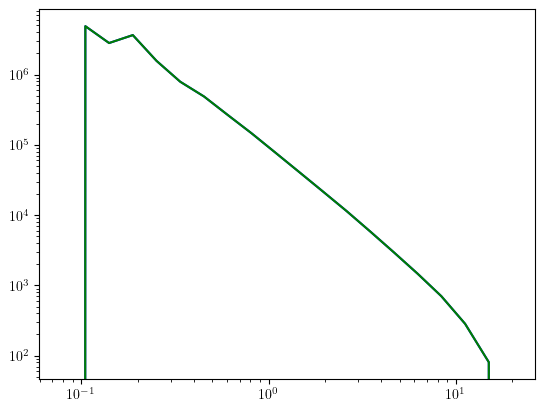

In [125]:
#plt.loglog(k, spectra_sf_s[2], color='red')
plt.loglog(k, spectra_sf[2], color='blue')
plt.loglog(k, spectra_sf_n[2], color='green')

In [83]:
pspecs_sf = np.load('pspecs_sf_z6.0155.npz')
pspecs_pl = np.load('pspecs_pl_z6.0155.npz')
pspecs_bt = np.load('pspecs_bt_z6.0155.npz')
pspecs_bt.files

['P_21cm_21cm',
 'P_21cm_CII',
 'P_21cm_OIII',
 'P_CII_CII',
 'P_CII_OIII',
 'P_OIII_OIII']

In [84]:
# plt.loglog(k, pspecs_bt['P_21cm_21cm'])
# plt.loglog(k, matter_pspec_6['P_m'])

In [85]:
# plt.plot(k, np.sqrt(pspecs_bt['P_21cm_21cm'] / matter_pspec_6['P_m']))
# plt.xscale('log')

In [86]:
# np.sqrt(pspecs_bt['P_21cm_21cm'] / matter_pspec_6['P_m'])[1:-1].mean()

In [87]:
# spectra_sf = [pspecs_sf['P_21cm_21cm'], pspecs_sf['P_21cm_CII'],
#                pspecs_sf['P_21cm_OIII'], pspecs_sf['P_CII_CII'],
#                pspecs_sf['P_CII_OIII'], pspecs_sf['P_OIII_OIII']]

# spectra_pl = [pspecs_pl['P_21cm_21cm'], pspecs_pl['P_21cm_CII'],
#                pspecs_pl['P_21cm_OIII'], pspecs_pl['P_CII_CII'],
#                pspecs_pl['P_CII_OIII'], pspecs_pl['P_OIII_OIII']]

# spectra_bt = [pspecs_bt['P_21cm_21cm'], pspecs_bt['P_21cm_CII'],
#                pspecs_bt['P_21cm_OIII'], pspecs_bt['P_CII_CII'],
#                pspecs_bt['P_CII_OIII'], pspecs_bt['P_OIII_OIII']]

In [88]:
def dimless(k, P):
    return k**3 / (2 * np.pi**2) * P

In [89]:
b_i_pl = np.sqrt(pspecs_pl['P_21cm_21cm'] / P_m)
b_j_pl = np.sqrt(pspecs_pl['P_CII_CII'] / P_m)
b_k_pl = np.sqrt(pspecs_pl['P_OIII_OIII'] / P_m)

P_ij_pl = b_i_pl * b_j_pl * P_m
P_jk_pl = b_j_pl * b_k_pl * P_m
P_ik_pl = b_i_pl * b_k_pl * P_m

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
b_i_bt = np.sqrt(pspecs_bt['P_21cm_21cm'] / P_m)
b_j_bt = np.sqrt(pspecs_bt['P_CII_CII'] / P_m)
b_k_bt = np.sqrt(pspecs_bt['P_OIII_OIII'] / P_m)

P_ij_bt = b_i_bt * b_j_bt * P_m
P_jk_bt = b_j_bt * b_k_bt * P_m
P_ik_bt = b_i_bt * b_k_bt * P_m

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


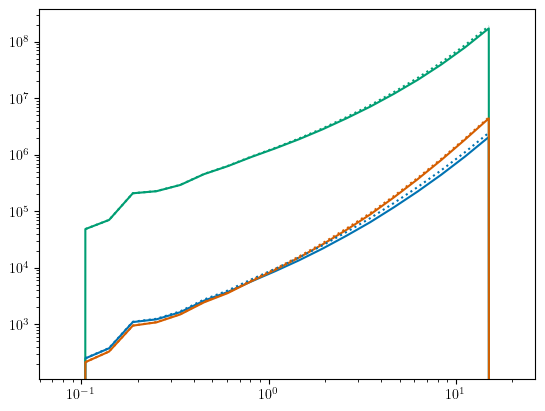

In [91]:
plt.loglog(k, (k**3 / (2 * np.pi**2)) * pspecs_pl['P_21cm_CII'], color=palette[0])
plt.loglog(k, (k**3 / (2 * np.pi**2)) * pspecs_pl['P_CII_OIII'], color=palette[1])
plt.loglog(k, (k**3 / (2 * np.pi**2)) * pspecs_pl['P_21cm_OIII'], color=palette[2])

plt.loglog(k, (k**3 / (2 * np.pi**2)) * P_ij_pl, color=palette[0], ls=':')
plt.loglog(k, (k**3 / (2 * np.pi**2)) * P_jk_pl, color=palette[1], ls=':')
plt.loglog(k, (k**3 / (2 * np.pi**2)) * P_ik_pl, color=palette[2], ls=':')

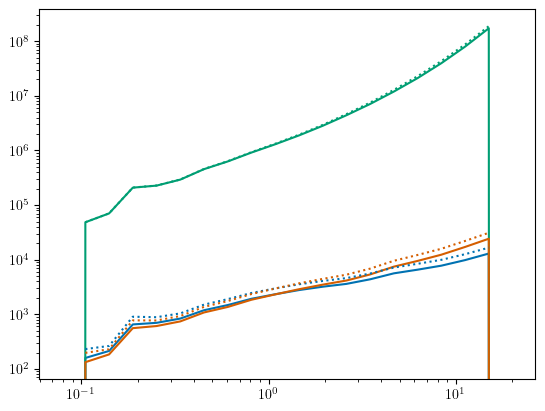

In [92]:
plt.loglog(k, (k**3 / (2 * np.pi**2)) * pspecs_bt['P_21cm_CII'], color=palette[0])
plt.loglog(k, (k**3 / (2 * np.pi**2)) * pspecs_bt['P_CII_OIII'], color=palette[1])
plt.loglog(k, (k**3 / (2 * np.pi**2)) * pspecs_bt['P_21cm_OIII'], color=palette[2])

plt.loglog(k, (k**3 / (2 * np.pi**2)) * P_ij_bt, color=palette[0], ls=':')
plt.loglog(k, (k**3 / (2 * np.pi**2)) * P_jk_bt, color=palette[1], ls=':')
plt.loglog(k, (k**3 / (2 * np.pi**2)) * P_ik_bt, color=palette[2], ls=':')

In [93]:
k[1:-1], spectra_pl[5][1:-1]#dimless(k[1:-1], spectra_pl[ind][1:-1])

(array([ 0.10513562,  0.14073752,  0.18839523,  0.25219119,  0.33759028,
         0.45190791,  0.60493672,  0.80978543,  1.08400171,  1.45107539,
         1.94245061,  2.60021941,  3.48072734,  4.6594002 ,  6.23720508,
         8.34929937, 11.17660861, 14.96132484]),
 array([1.95446362e+09, 1.20590597e+09, 1.46926697e+09, 6.79776936e+08,
        3.74561189e+08, 2.47483736e+08, 1.45271042e+08, 9.21316064e+07,
        5.68663766e+07, 3.61746058e+07, 2.39507660e+07, 1.66404848e+07,
        1.20189921e+07, 9.25577145e+06, 7.50347531e+06, 6.48961643e+06,
        5.96862595e+06, 5.77171650e+06]))

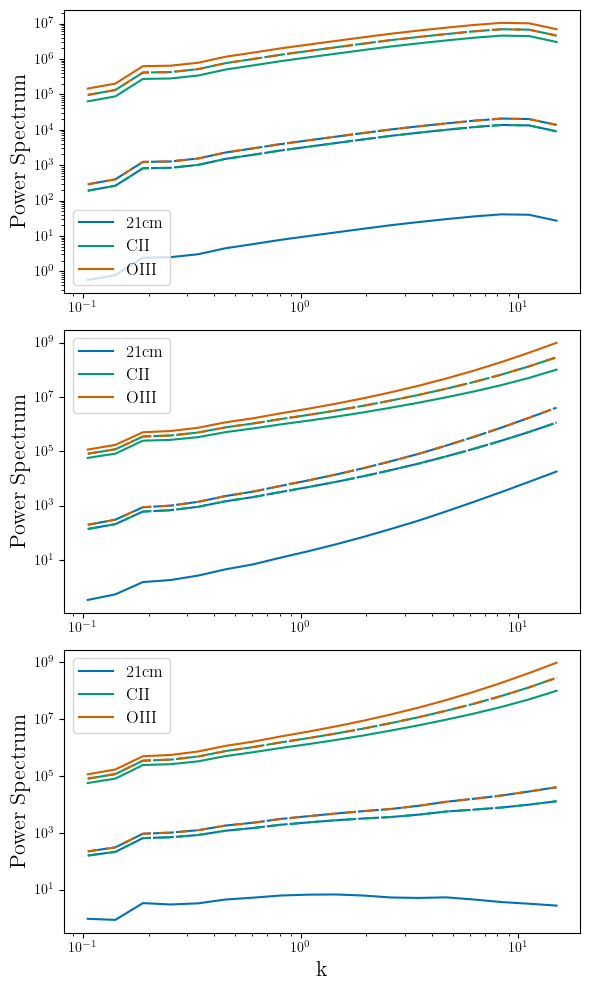

In [94]:
fig, ax = plt.subplots(3,1)

fig.set_figheight(10)
fig.set_figwidth(6)

autos = [0,3,5]
cross = [1,2,4]

lines = [[]for i in range(3)]
line_labels = ['21cm', 'CII', 'OIII']


for i, ind in enumerate(autos):
    lines[i], = ax[0].loglog(k[1:-1], dimless(k[1:-1], spectra_sf[ind][1:-1]), marker='None', color=palette[i])
    
    ax[1].loglog(k[1:-1], dimless(k[1:-1], spectra_pl[ind][1:-1]), marker='None')

    ax[2].loglog(k[1:-1], dimless(k[1:-1], spectra_bt[ind][1:-1]), marker='None')
    
for i, ind in enumerate(cross):
    line1 = int(indices[ind][0])
    line2 = int(indices[ind][1])
    ax[0].loglog(k[1:-1], dimless(k[1:-1], spectra_sf[ind][1:-1]), marker='None', ls='--', 
                                                                 dashes=(10, 1), color=palette[line1])
    
    ax[0].loglog(k[1:-1], dimless(k[1:-1], spectra_sf[ind][1:-1]), marker='None', ls='--',
                 dashes=(5, 4), color=palette[line2])
    
    ax[1].loglog(k[1:-1], dimless(k[1:-1], spectra_pl[ind][1:-1]), marker='None', ls='--', 
                                                                 dashes=(10, 1), color=palette[line1])
    
    ax[1].loglog(k[1:-1], dimless(k[1:-1], spectra_pl[ind][1:-1]), marker='None', ls='--',
                 dashes=(5, 4), color=palette[line2])
    
    ax[2].loglog(k[1:-1], dimless(k[1:-1], spectra_bt[ind][1:-1]), marker='None', ls='--', 
                                                                 dashes=(10, 1), color=palette[line1])
    
    ax[2].loglog(k[1:-1], dimless(k[1:-1], spectra_bt[ind][1:-1]), marker='None', ls='--',
                 dashes=(5, 4), color=palette[line2])
#plt.loglog(k[1:-1], spectra[label[1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
#                                                       line_labels[int(indices[3][1])]))

#plt.loglog(k[1:-1], spectra[1][5][1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
#                                                       line_labels[int(indices[5][1])]))

#ax[0].set_xlabel('k',fontsize=16)
#ax[1].set_xlabel('k',fontsize=16)
ax[2].set_xlabel('k',fontsize=16)

ax[0].set_ylabel('Power Spectrum', fontsize=16)
ax[1].set_ylabel('Power Spectrum', fontsize=16)
ax[2].set_ylabel('Power Spectrum', fontsize=16)

ax[0].legend(lines, line_labels, fontsize=12)
ax[1].legend(lines, line_labels, fontsize=12)
ax[2].legend(lines, line_labels, fontsize=12)

fig.tight_layout()
fig.savefig('pspecs.pdf')

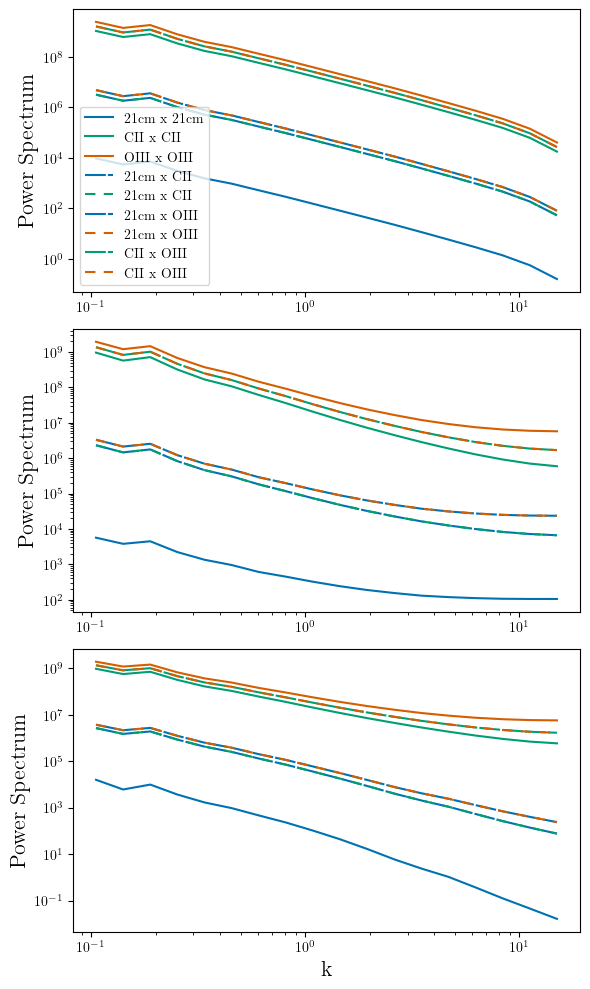

In [95]:
fig, ax = plt.subplots(3,1)

fig.set_figheight(10)
fig.set_figwidth(6)

autos = [0,3,5]
cross = [1,2,4]

line_labels = ['21cm', 'CII', 'OIII']

for i, ind in enumerate(autos):
    ax[0].loglog(k[1:-1], spectra_sf[ind][1:-1], marker='None',
            label=r'{} x {} '.format(line_labels[int(indices[ind][0])],
                                                       line_labels[int(indices[ind][1])]), color=palette[i])
    
    ax[1].loglog(k[1:-1], spectra_pl[ind][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[ind][0])],
                                                   line_labels[int(indices[ind][1])]))

    ax[2].loglog(k[1:-1], spectra_bt[ind][1:-1], marker='None',
    label=r'{} x {} '.format(line_labels[int(indices[ind][0])],
                                               line_labels[int(indices[ind][1])]))
    
for i, ind in enumerate(cross):
    line1 = int(indices[ind][0])
    line2 = int(indices[ind][1])
    ax[0].loglog(k[1:-1], spectra_sf[ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--', 
                                                                 dashes=(10, 1), color=palette[line1])
    
    ax[0].loglog(k[1:-1], spectra_sf[ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--',
                 dashes=(5, 4), color=palette[line2])
    
    ax[1].loglog(k[1:-1], spectra_pl[ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--', 
                                                                 dashes=(10, 1), color=palette[line1])
    
    ax[1].loglog(k[1:-1], spectra_pl[ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--',
                 dashes=(5, 4), color=palette[line2])
    
    ax[2].loglog(k[1:-1], spectra_bt[ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--', 
                                                                 dashes=(10, 1), color=palette[line1])
    
    ax[2].loglog(k[1:-1], spectra_bt[ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--',
                 dashes=(5, 4), color=palette[line2])
#plt.loglog(k[1:-1], spectra[label[1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
#                                                       line_labels[int(indices[3][1])]))

#plt.loglog(k[1:-1], spectra[1][5][1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
#                                                       line_labels[int(indices[5][1])]))

#ax[0].set_xlabel('k',fontsize=16)
#ax[1].set_xlabel('k',fontsize=16)
ax[2].set_xlabel('k',fontsize=16)

ax[0].set_ylabel('Power Spectrum', fontsize=16)
ax[1].set_ylabel('Power Spectrum', fontsize=16)
ax[2].set_ylabel('Power Spectrum', fontsize=16)

ax[0].legend(fontsize=10)

fig.tight_layout()
fig.savefig('pspecs.pdf')

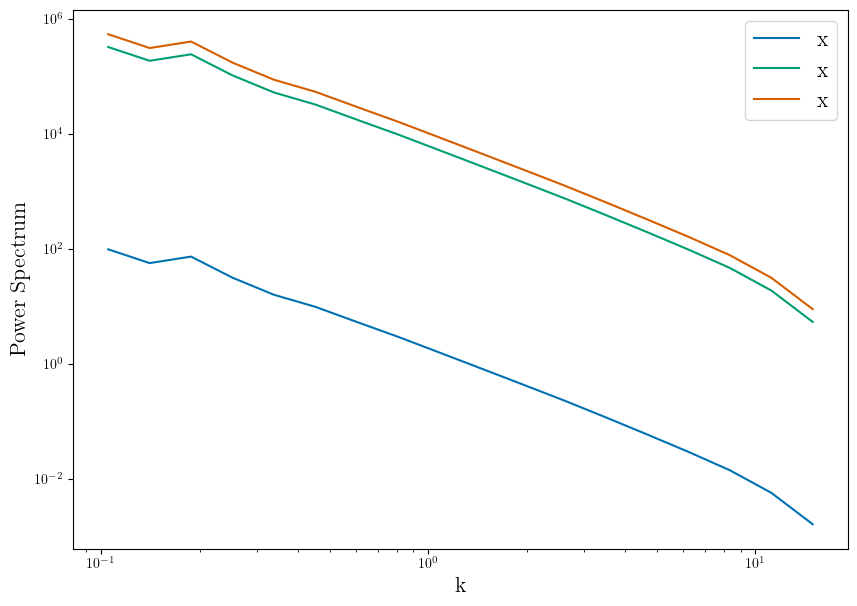

In [96]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = ['P_21cm_21cm', 'P_21cm_CII', 'P_21cm_OIII']

for label in line_labels:
#ax.axvline(k[9], color='black', ls='--', alpha=.2)

#plt.loglog(k, Lidz_pspec_log, label='Lidz log')
    #legend_label = r*label

    plt.loglog(k[1:-1], pspecs_sf[label][1:-1], marker='None',
            label=r'x')

#plt.loglog(k[1:-1], spectra[label[1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
#                                                       line_labels[int(indices[3][1])]))

#plt.loglog(k[1:-1], spectra[1][5][1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
#                                                       line_labels[int(indices[5][1])]))


plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

Let's plot the power spectrum, $P(k)$,

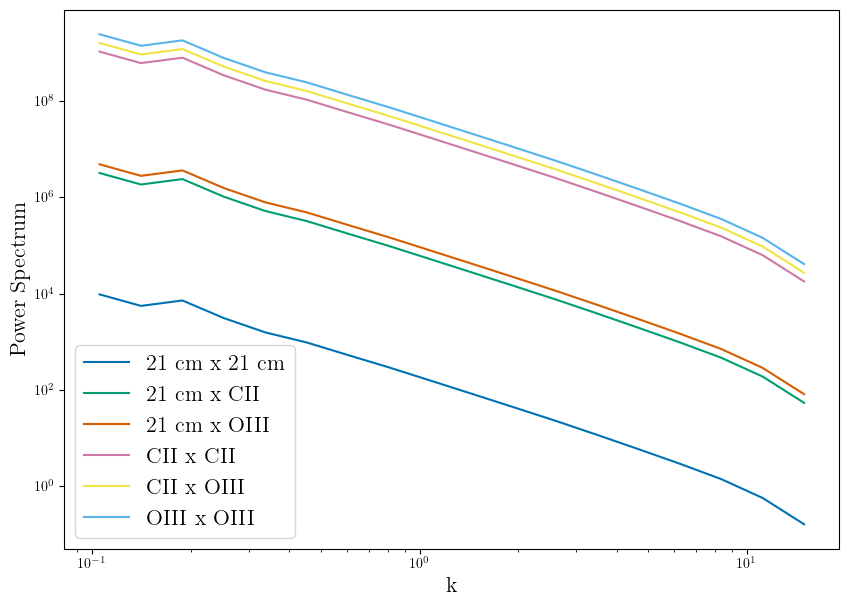

In [97]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_sf)):
    plt.loglog(k[1:-1], spectra_sf[i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

and the dimensionless power spectrum, $\Delta(k)$,

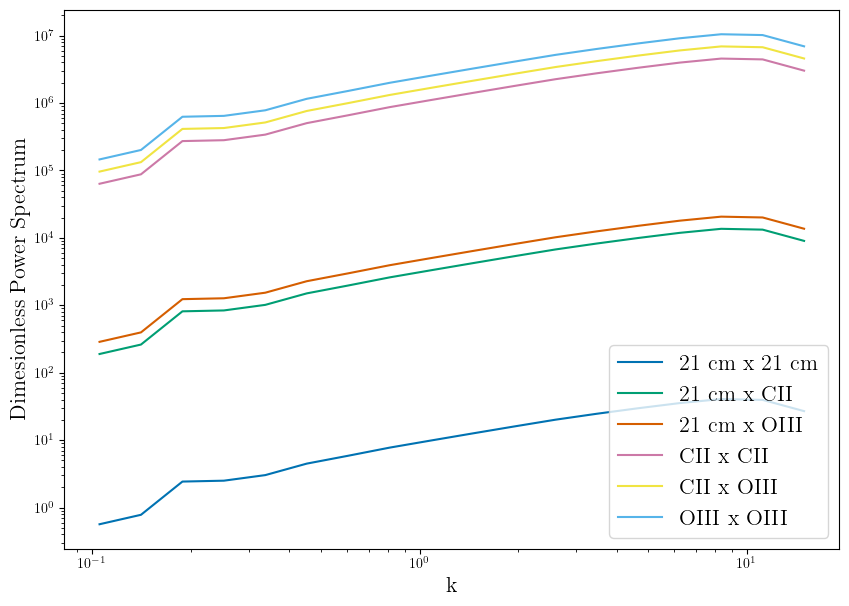

In [98]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_sf)):
    plt.loglog(k[1:-1], (k[1:-1]**3 / (2 * np.pi**2)) * spectra_sf[i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Dimesionless Power Spectrum', fontsize=16)


plt.legend(fontsize=16)

### Comparing amplitudes with Lidz et al.

We want to make sure that our spectra are reasonable.

#### Autocorrelations

In [99]:
P_21cm_21cm = spectra_bt[0] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_CII_CII = spectra_bt[3] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_OIII_OIII = spectra_bt[5] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)

#### Crosscorrelations 

In [100]:
P_21cm_CII = spectra_bt[1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_21cm_OIII = spectra_bt[2] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_CII_OIII = spectra_bt[4] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)

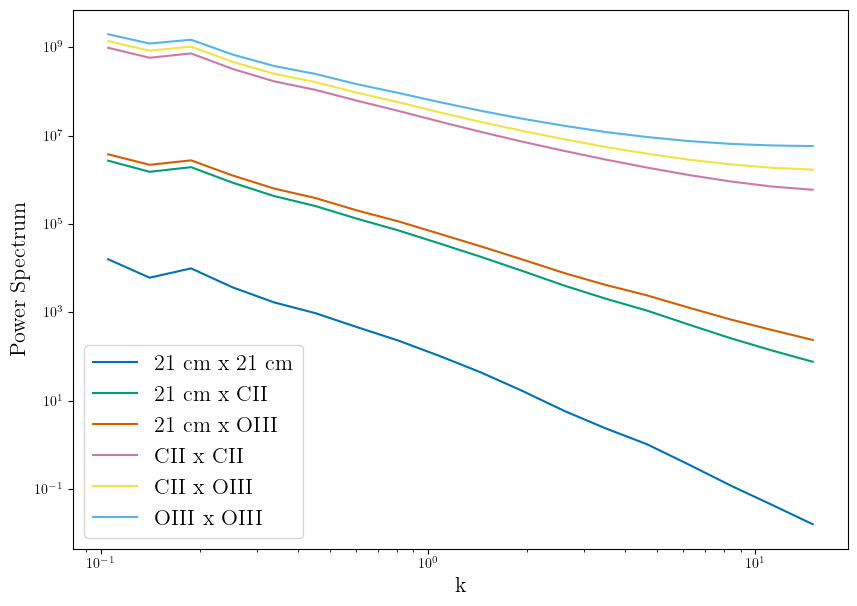

In [101]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_bt)):
    plt.loglog(k[1:-1], spectra_bt[i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

# Surveys

test with different values of the power index, alpha

In [102]:
r_vec.shape

(3, 512)

In [103]:
r_vec[0][-1] - r_vec[0][-2]

0.15655577299413892

### Checking the resolution of the instrument

The maximum resolvable $k$ of the instrument is set by the size of the survey volume. This is roughly,
$$
V \approx R^2(z)\Omega \left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]
$$
Where the term $\sqrt{R(z)^2 \Omega}$ sets the minimum $k_{\perp}$ and $\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]$ sets the minimum $k_{\parallel}$.

Then the maximum resolution is,
$$k_{\text{max}} = \sqrt{k_{\perp, \text{max}}^2 + k_{\parallel, \text{max}}^2} \\
= \sqrt{\left( \frac{4 \pi}{\sqrt{R(z)^2 \Omega}} \right)^2 + \left(\frac{2 \pi}{\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]}\right)^2 }
$$

### Survey specifications

We now want to construct three surveys that have the same coverage in 2D k-space, such that we can perform cross correlations. We want three different lines, corresponding to 21 cm, CII, and OIII.

# Fitting

Now that we have our simulated data, and our survey specifications, we can now run our full simulations and recover the best fit parameters.

## Cases 

Let's investigate a series of different scenarios. Let's start idealized and then progress one step at a time.

Let's initialize our simulations with the desired specifications.  Let's set three different noise levels: optimistic, conservative, pessimistic.

In [27]:
k_indices = [6]
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])

frac_op = .01
frac_con = .1
frac_pess = .25

In [105]:
def run_all_k(spectra, params):
    for ind, val in enumerate(k[:-1]):
        spectra_noise, std = analysis.noisey_spectra(spectra[1], std_spectra=std_surveys)
        data = utils.fetch_data(k_indices, spectra_noise, b_0=params['b_i'])
        N, n = analysis.get_noise(k_indices, std, params['b_i'])

        Beane = fitting.Beane_et_al(spectra, n[0], n[1], n[2], N_modes, k_indices)
        
        LSE = fitting.LSE_results(k_indices, data, N)
        LSE_params, LSE_var = utils.add_P_ii([LSE[0], LSE[1]])
  
        MCMC = fitting.MCMC_results(params, k_indices, data, model, N, nsteps=1e5)
        P_ii_samples = analysis.add_P(MCMC[0], k_indices, (0,0))
        P_ii_arg = MCMC[1][0:-1:100].argmax()
        
        all_k_data[ind] = data
        all_k_Beane[ind] = Beane[0][ind], Beane[1][ind]
        all_k_LSE[ind] = LSE_params[-1], np.sqrt(LSE_var[-1])
        all_k_mcmc[ind] = P_ii_samples[ind][-1], np.std(P_ii_samples[-1])

In [106]:
# spectra = spectra_sf[1]
# params = params_sf

# for ind, val in enumerate(k[:-1]):
#     spectra_noise, std = analysis.noisey_spectra(np.asarray(spectra)[:,:-1], std_spectra=std_surveys)
#     data = utils.fetch_data(k_indices, spectra_noise, b_0=params['b_i'])
#     N, n = analysis.get_noise(k_indices, std, params['b_i'])

#     Beane = fitting.Beane_et_al(spectra_noise, n[0], n[1], n[2], N_modes[:-1], k_indices)

#     LSE = fitting.LSE_results(k_indices, data, N)
#     LSE_params, LSE_var = utils.add_P_ii([LSE[0], LSE[1]])

#     MCMC = fitting.MCMC_results(params, k_indices, data, model, N, nsteps=1e5)
#     P_ii_samples = analysis.add_P(MCMC[0], k_indices, (0,0))
#     P_ii_ind = MCMC[1][0:-1:100].argmax()

#     all_k_data[ind] = data[1:-1]
#     all_k_Beane[ind] = Beane[0][ind], Beane[1][ind]
#     all_k_LSE[ind] = LSE_params[-1], np.sqrt(LSE_var[-1])
#     all_k_mcmc[ind] = P_ii_samples[P_ii_ind][-1], np.std(P_ii_samples[-1])

## Least Square Estimators

We first want to fit our data using our least squares formalism,

We want these results in our original parameterization.  The standard expression for the propagation of uncertainty is given by,

$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

We have two cases:

1) a parameter that looks like $b = e^{i \eta}$,

then,
$\sigma_b = \sqrt{\left( \frac{\partial f(\eta)}{\partial \eta} \right)^2 \sigma_\eta^2}$

$= \sqrt{\left( \frac{\partial}{\partial \eta} e^{\eta} \right)^2 \sigma_\eta^2}$

$= \sqrt{ \left( e^{\eta} \right)^2 \sigma_\eta^2}$

$\sigma_b = e^{\eta} \eta$

2) fitting $\ln{P_m}$ in lieu of $P_m$,

with $f(x) = e^x$ and $x=\ln{P_m}$, yielding,

$\sigma_{P_m} = \sqrt{\left( \frac{\partial }{\partial(\ln{P_m})}\left[ e^{\ln{P_m}} \right] \right)^2 \sigma_{\ln{P_m}}^2} $

$= \sqrt{\left(e^{\ln{P_m}}\right)^2 \sigma_{\ln{P_m}}^2}$
$= \sqrt{P^2_m \sigma_{\ln{P_m}}^2}$

$\sigma_{P_m} = P_m \sigma_{\ln{P_m}}$

### Superfake data and superfake noise levels

In [28]:
k_indices = [6]
frac_error = .01

biases_sf = utils.extract_bias(k_indices, spectra_sf, P_m)
p_vals_sf = np.asarray([*biases_sf, P_m], dtype=object)

params_sf = dict(zip(p_names, p_vals_sf))
ndim = utils.get_params(params_sf, k_indices).size

p_sf_tot = np.zeros(ndim+1)
for i in range(ndim):
    p_sf_tot[i] = utils.get_params(params_sf, k_indices)[i]
p_sf_tot[-1] = spectra_sf[0][k_indices]  

N_modes_small = survey.calc_N_modes(k, 80**3 * u.Mpc**3, align='left')

# CAREFUL! First is var, second is std
N, n = analysis.get_noise(k_indices, spectra_sf, params_sf['b_i'], N_modes_small,
                          frac_error=frac_error)

data_sf = utils.fetch_data(k_indices,spectra_sf, b_0=params_sf['b_i'])
N_sf = analysis.estimate_errors(data_sf, frac_error=frac_error)

data_sf_noise = analysis.inject_noise(data_sf, N)

model = models.ScalarBias_crossonly(k=k, params=params_sf)

#N = analysis.create_noise_matrix(k_indices, variances)

In [42]:
indices, k_indices

(array([[0., 0.],
        [0., 1.],
        [0., 2.],
        [1., 1.],
        [1., 2.],
        [2., 2.]]),
 [6])

In [47]:
data, Beane, LSE, MCMC = analysis.run_analysis(k_indices, spectra_sf, params_sf,
                                               [np.ones_like(k), np.ones_like(k), np.ones_like(k),
                                               np.ones_like(k), np.ones_like(k), np.ones_like(k)],
                                               model, N_modes=N_modes_small,
                    data=None, error_x=False, priors_width=.10, priors_offset=1.0,
                    noiseless=True, nsteps=1e3)

noiseless run, easy breezy!
PARAMS:  {'b_i': 12.395660540370898, 'b_j': 3300.0, 'b_k': 5000.0, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [4.04939619e+05 1.63339266e+08 6.13544877e+05]
NOISE:  [1. 1. 1.]
PRIOR RANGE:  0.1
PRIOR GUESS: 12.395660540370898
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior guess is: 12.395660540370898
prior width is:  0.1
positivity prior is:  False
pdf is:  gaussian
nsteps:  1000.0
logp of truths is: 0.0
no backend initialized


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 184.06it/s]


In [48]:
data, Beane, LSE, MCMC = analysis.keep_P_21(k_indices, spectra_sf, params_sf,
                                            [np.ones_like(k), np.ones_like(k), np.ones_like(k),
                                               np.ones_like(k), np.ones_like(k), np.ones_like(k)], model,
                                            N_modes=N_modes_small, noiseless=True, nsteps=1e3,
                                           error_x=False)

noiseless run, easy breezy!
PARAMS:  {'b_i': 12.395660540370898, 'b_j': 3300.0, 'b_k': 5000.0, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [4.04939619e+05 1.63339266e+08 6.13544877e+05]
NOISE:  [1. 1. 1.]
PRIOR RANGE:  0.1
PRIOR GUESS: 12.395660540370898
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior guess is: 12.395660540370898
prior width is:  0.1
positivity prior is:  False
pdf is:  gaussian
nsteps:  1000.0
logp of truths is: 0.0
no backend initialized


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 133.65it/s]


In [110]:
np.savez('test', data=data, Beane=Beane, LSE=LSE, samples=MCMC[0], logp=MCMC[1])

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [ ]:
### Superfake data and superfake noise levels

biases_bt = utils.extract_bias(k_indices, spectra_bt, P_m)
p_vals_bt = np.asarray([*biases_bt, P_m], dtype=object)

params_bt = dict(zip(p_names, p_vals_bt))
ndim = utils.get_params(params_bt, k_indices).size
model = models.ScalarBias_crossonly(k=spectra_bt[0], params=params_bt)
N_modes_small = survey.calc_N_modes(k, 80**3 * u.Mpc**3, align='left')

for i, n in enumerate(noise):
    t0 = time.time()
    print('Now on noise level',n,'%')
    nsteps = int(1e6)
    if n > .1:
        nsteps = int(1e7)

    data_nl, Beane_nl, LSE_nl, MCMC_nl = analysis.keep_P_21(k_indices, spectra_bt, params_bt, n, model,
                                            N_modes=N_modes_small, noiseless=False, nsteps=nsteps,
                                            backend_filename=f'noise_{n}_bt_nl_z6.0155.h5')
    data, Beane, LSE, MCMC = analysis.keep_P_21(k_indices, spectra_bt, params_bt, n, model,
                                            N_modes=N_modes_small, noiseless=True, nsteps=nsteps,
                                            backend_filename=f'noise_{n}_bt_z6.0155.h5')


    np.savez(f'noise_{n}_bt_nl_z6.0155', data=data_nl, Beane=Beane_nl, LSE=LSE_nl, sambtes=MCMC_nl[0], logp=MCMC_nl[1])
    np.savez(f'noise_{n}_bt_z6.0155', data=data, Beane=Beane, LSE=LSE, sambtes=MCMC[0], logp=MCMC[1])

    tf = time.time()
    print(f'run {i} saved to disk')
    print('time to combtete brightness temperature run {i} is:', (tf - t0) / 60, 'minutes')


In [111]:
# data_sf_nl, Beane_sf_nl, LSE_sf_nl, MCMC_sf_nl = analysis.run_analysis(k_indices, spectra_sf, params_sf,
#                                                                 .3, model, noiseless=True)


In [112]:
analysis.plot_corner(MCMC_sf_nl[0], LSE_sf_nl, Beane_sf_nl, params_sf,
                     MCMC_sf_nl[1], spectra_sf[0], k_indices)

NameError: name 'MCMC_sf_nl' is not defined

In [ ]:
sf_results = np.load('higher_noise_results/sf_results_z6.0155.npz', allow_pickle=True)
pl_results = np.load('higher_noise_results/pl_results_z6.0155.npz', allow_pickle=True)
bt_results = np.load('higher_noise_results/bt_results_z6.0155.npz', allow_pickle=True)
sf_results.files

In [ ]:
corner.corner(sf_results['MCMC_pess_samples'], truths=p_sf_tot[:-1])

In [ ]:
plt.loglog(k, P_m)
plt.loglog(k, biases_sf[0]**2 * P_m)
plt.loglog(k, spectra_sf[1][0])
plt.loglog(k, spectra_sf[1][1] * spectra_sf[1][2] / spectra_sf[1][4])

In [ ]:
(spectra_sf[1][1] * spectra_sf[1][2] / spectra_sf[1][4])[k_indices]

In [ ]:
spectra_sf[1][1][k_indices], spectra_sf[1][4][k_indices], spectra_sf[1][2][k_indices]

In [ ]:
p_sf_tot, Beane_sf_nl, LSE_sf_nl[0]

In [ ]:
p_sf_tot, Beane_sf_op[0], LSE_sf_op[0][0]**2 * LSE_sf_op[0][-1]

In [ ]:
frac_pess = .1
frac_op = .001

### Perfect biasing model

In [ ]:
data_sf_op, Beane_sf_op, LSE_sf_op, MCMC_sf_op = analysis.run_analysis(k_indices, spectra_sf[1],
                                            params_sf, N_modes, frac_op, model)

In [ ]:
LSE_sf_op, p_sf_tot

In [ ]:
Beane_sf_nl, LSE_sf_nl, MCMC_sf_nl = analysis.run_analysis(k_indices, spectra_sf[1],
                                                           params_sf, N_modes,
                                                           frac_pess, model,
                                                              noiseless=True)

In [ ]:
fig_sf = analysis.plot_corner(sf_results['MCMC_nl_samples'],
                              sf_results['LSE_sf_nl'],
                              sf_results['Beane_sf_nl'], params_sf, sf_results['MCMC_nl_logp'],
                              spectra_sf[1][0], k_indices,
                        'gray', fig=None)

In [ ]:
fig_sf, limits = analysis.plot_corner(sf_results['MCMC_nl_samples'],
                              sf_results['LSE_sf_nl'],
                              sf_results['Beane_sf_nl'], params_sf, sf_results['MCMC_nl_logp'],
                              spectra_sf[1][0], k_indices,
                        ccolor='gray', fig=None, limits=None)

In [ ]:
fig_sf, limits = analysis.plot_corner(sf_results['MCMC_pess_samples'],
                              sf_results['LSE_sf_pess'],
                              sf_results['Beane_sf_pess'], params_sf, sf_results['MCMC_pess_logp'],
                              spectra_sf[1][0], k_indices,
                        'deeppink', fig=fig_sf, limits=limits)

fig_sf

In [ ]:
fig_sf, limits = analysis.plot_corner(sf_results['MCMC_con_samples'],
                              sf_results['LSE_sf_con'],
                              sf_results['Beane_sf_con'], params_sf, sf_results['MCMC_con_logp'],
                              spectra_sf[1][0], k_indices,
                        ccolor='gold', fig=fig_sf, limits=limits)
limits

In [ ]:
fig_sf, limits = analysis.plot_corner(sf_results['MCMC_op_samples'],
                              sf_results['LSE_sf_op'],
                              sf_results['Beane_sf_op'], params_sf, sf_results['MCMC_op_logp'],
                              spectra_sf[1][0], k_indices,
                        ccolor='deepskyblue', fig=fig_sf, limits=limits)
fig_sf

### Simulated power law data and fractional noise error

In [ ]:
k_indices = [6]
frac_error = .01

biases_pl = utils.extract_bias(k_indices, spectra_pl[1], P_m)
p_vals_pl = np.asarray([*biases_pl, P_m], dtype=object)

params_pl = dict(zip(p_names, p_vals_pl))
ndim = utils.get_params(params_pl, k_indices).size

p_pl_tot = np.zeros(ndim+1)
for i in range(ndim):
    p_pl_tot[i] = utils.get_params(params_pl, k_indices)[i]
p_pl_tot[-1] = spectra_pl[1][0][k_indices]    

# CAREFUL! First is var, second is std
N, n = analysis.get_noise(k_indices, spectra_pl[1], params_pl['b_i'], N_modes,
                          frac_error=frac_error)

data = utils.fetch_data(k_indices,spectra_pl[1], b_0=params_pl['b_i'])
N = analysis.estimate_errors(data, frac_error=frac_error)

data_noise = analysis.inject_noise(data, N)

model = models.ScalarBias_crossonly(k=spectra_pl[0], params=params_pl)

#N = analysis.create_noise_matrix(k_indices, variances)

In [ ]:
pl_results.files

In [ ]:
fig_pl, limits = analysis.plot_corner(pl_results['MCMC_nl_samples'],
                              pl_results['LSE_pl_nl'],
                              pl_results['Beane_pl_nl'], params_pl, pl_results['MCMC_nl_logp'],
                              spectra_pl[1][0], k_indices,
                        ccolor='gray', fig=None, limits=None)

In [ ]:
fig_pl, limits = analysis.plot_corner(pl_results['MCMC_pess_samples'],
                              pl_results['LSE_pl_pess'],
                              pl_results['Beane_pl_pess'], params_pl, pl_results['MCMC_pess_logp'],
                              spectra_pl[1][0], k_indices,
                        'deeppink', fig=fig_pl, limits=limits)

fig_pl

In [ ]:
fig_pl, limits = analysis.plot_corner(pl_results['MCMC_con_samples'],
                              pl_results['LSE_pl_con'],
                              pl_results['Beane_pl_con'], params_pl, pl_results['MCMC_con_logp'],
                              spectra_pl[1][0], k_indices,
                        ccolor='gold', fig=fig_pl, limits=limits)


fig_pl

In [ ]:
fig_sf, limits = analysis.plot_corner(sf_results['MCMC_op_samples'],
                              sf_results['LSE_sf_op'],
                              sf_results['Beane_sf_op'], params_sf, sf_results['MCMC_op_logp'],
                              spectra_sf[1][0], k_indices,
                        ccolor='deepskyblue', fig=None, limits=None)
fig_sf

In [ ]:
fig_sf, limits = analysis.plot_corner(sf_results['MCMC_con_samples'],
                              sf_results['LSE_sf_con'],
                              sf_results['Beane_sf_con'], params_sf, sf_results['MCMC_con_logp'],
                              spectra_sf[1][0], k_indices,
                        ccolor='orange', fig=None, limits=None)

### Power Law Results

In [ ]:
np.savez('pl_results', data_pl_op=data_pl_op, data_pl_con=data_pl_con, data_pl_pess=data_pl_pess,
                     Beane_pl_op=Beane_pl_op, Beane_pl_con=Beane_pl_con, Beane_pl_pess=Beane_pl_pess,
                     LSE_pl_op=LSE_pl_op, LSE_pl_con=LSE_pl_con, LSE_pl_pess=LSE_pl_pess, 
                     MCMC_pl_op=MCMC_op, MCMC_pl_con=MCMC_con, MCMC_pl_pess=MCMC_pess)

In [ ]:
analysis.plot_corner('pl_op.pdf', MCMC_pl_op, LSE_pl_op, Beane_pl_op, params_pl, spectra_pl[1][0], k_indices)

In [ ]:
analysis.plot_corner('pl_con.pdf', MCMC_pl_con, LSE_pl_con, Beane_pl_con, params_pl, spectra_pl[1][0], k_indices)

In [ ]:
analysis.plot_corner('pl_pess.pdf', MCMC_pl_pess, LSE_pl_pess, Beane_pl_pess, params_pl, spectra_pl[1][0],
                     k_indices)

### Simulated brightness temperature data and fractional noise error

In [ ]:
k_indices = [6]
frac_error = .01

biases_bt = utils.extract_bias(k_indices, spectra_bt[1], P_m)
p_vals_bt = np.asarray([*biases_bt, P_m], dtype=object)

params_bt = dict(zip(p_names, p_vals_bt))
ndim = utils.get_params(params_bt, k_indices).size

p_bt_tot = np.zeros(ndim+1)
for i in range(ndim):
    p_bt_tot[i] = utils.get_params(params_bt, k_indices)[i]
p_bt_tot[-1] = spectra_bt[1][0][k_indices]    

# CAREFUL! First is var, second is std
N, n = analysis.get_noise(k_indices, spectra_bt[1], params_bt['b_i'], N_modes,
                          frac_error=frac_error)

data = utils.fetch_data(k_indices,spectra_bt[1], b_0=params_bt['b_i'])
N = analysis.estimate_errors(data, frac_error=frac_error)

data_noise = analysis.inject_noise(data, N)

model = models.ScalarBias_crossonly(k=spectra_bt[0], params=params_bt)

#N = analysis.create_noise_matrix(k_indices, variances)

In [ ]:
fig_bt, limits = analysis.plot_corner(bt_results['MCMC_nl_samples'],
                              bt_results['LSE_bt_nl'],
                              bt_results['Beane_bt_nl'], params_bt, bt_results['MCMC_nl_logp'],
                              spectra_bt[1][0], k_indices,
                        ccolor='gray', fig=None, limits=None)

In [ ]:
fig_bt, limits = analysis.plot_corner(bt_results['MCMC_pess_samples'],
                              bt_results['LSE_bt_pess'],
                              bt_results['Beane_bt_pess'], params_bt, bt_results['MCMC_pess_logp'],
                              spectra_bt[1][0], k_indices,
                        'deeppink', fig=fig_bt, limits=limits)

fig_bt

In [ ]:
fig_bt, limits = analysis.plot_corner(bt_results['MCMC_con_samples'],
                              bt_results['LSE_bt_con'],
                              bt_results['Beane_bt_con'], params_bt, bt_results['MCMC_con_logp'],
                              spectra_bt[1][0], k_indices,
                        ccolor='gold', fig=fig_bt, limits=limits)
limits

In [ ]:
fig_bt, limits = analysis.plot_corner(bt_results['MCMC_op_samples'],
                              bt_results['LSE_bt_op'],
                              bt_results['Beane_bt_op'], params_bt, bt_results['MCMC_op_logp'],
                              spectra_bt[1][0], k_indices,
                        ccolor='deepskyblue', fig=fig_bt, limits=limits)
fig_bt

In [ ]:
x = np.linspace(0, 10)

In [ ]:
plt.plot(np.sqrt(2 * x**2), x)

### Brightness Temperature Results

In [ ]:
np.savez('bt_results', data_bt_op=data_bt_op, data_bt_con=data_bt_con, data_bt_pess=data_bt_pess,
                     Beane_bt_op=Beane_bt_op, Beane_bt_con=Beane_bt_con, Beane_bt_pess=Beane_bt_pess,
                     LSE_bt_op=LSE_bt_op, LSE_bt_con=LSE_bt_con, LSE_bt_pess=LSE_bt_pess, 
                     MCMC_bt_op=MCMC_op, MCMC_bt_con=MCMC_con, MCMC_bt_pess=MCMC_pess)

In [ ]:
analysis.plot_corner('bt_op.pdf', MCMC_bt_op, LSE_bt_op, Beane_bt_op, params_bt, spectra_bt[1][0], k_indices)

In [ ]:
analysis.plot_corner('bt_con.pdf', MCMC_bt_con, LSE_bt_con, Beane_bt_con, params_bt, spectra_bt[1][0], k_indices)

In [ ]:
analysis.plot_corner('bt_pess.pdf', MCMC_bt_pess, LSE_bt_pess, Beane_bt_pess, params_bt, spectra_bt[1][0],
                     k_indices)

In [ ]:
indices

In [ ]:
P_N_21cm_HERA

## Higher noise

In [ ]:
N_modes_check = survey.find_N_modes(.1, spectra_sf[0] * (u.Mpc**3 * u.Jansky**2 * u.steradian**(-2)),
                        spectra_sf[3] * (u.Mpc**3 * u.Jansky**2 * u.steradian**(-2)),
                        P_N_21cm_HERA, P_N_CII_StageII,
                        spectra_sf[1] * (u.Mpc**3 * u.Jansky**2 * u.steradian**(-2)))

In [ ]:
var_check = survey.var_x(spectra_sf[0] * (u.Mpc**3 * u.Jansky**2 * u.steradian**(-2)), 1.0,
                        spectra_sf[3] * (u.Mpc**3 * u.Jansky**2 * u.steradian**(-2)),
                        1.0, P_N_21cm_HERA, P_N_CII_StageII,
                        spectra_sf[1] * (u.Mpc**3 * u.Jansky**2 * u.steradian**(-2)),
                        N_modes_check)

In [ ]:
pspecs_sf['P_21cm_CII'] / spectra_sf[1]

### On the question of priors

Here we investigate the effect of a wrong prior is on the recovered P21 autocorrelation.

In [ ]:
priors_range = np.linspace(.5,1.0,11)
priors_sf = np.load('prior_sf_stats.npz')

In [ ]:
priors_sf.files

In [ ]:
priors_sf['P_21_Beane'][:,0]

In [ ]:
spectra_sf[0][k_indices]

In [ ]:
plt.plot(priors_range, priors_sf['P_21_Beane'][:,0], marker='o', ls='None')
plt.plot(priors_range, priors_sf['P_21_Beane'][:,1], marker='o', ls='None')

plt.plot(priors_range, priors_sf['P_21_MCMC_median'][:,0], marker='o', ls='None')
plt.plot(priors_range, priors_sf['P_21_MCMC_median'][:,1], marker='o', ls='None')

plt.plot(priors_range, priors_sf['P_21_MCMC_maxlogp'][:,0], marker='o', ls='None')
plt.plot(priors_range, priors_sf['P_21_MCMC_maxlogp'][:,1], marker='o', ls='None')

plt.axhline(spectra_sf[0][k_indices])

In [ ]:
print('superfake analysis')

### Superfake data and superfake noise levels

biases_pl = utils.extract_bias(k_indices, spectra_pl, P_m)
p_vals_pl = np.asarray([*biases_pl, P_m], dtype=object)

params_pl = dict(zip(p_names, p_vals_pl))
ndim = utils.get_params(params_pl, k_indices).size
model = models.ScalarBias_crossonly(k=spectra_pl[0], params=params_pl)
N_modes_small = survey.calc_N_modes(k, 80**3 * u.Mpc**3, align='left')

P_21_Beane = np.zeros((priors.size, 2))
P_21_MCMC_median = np.zeros((priors.size, 2))
P_21_MCMC_maxlogp = np.zeros((priors.size, 2))

var_21_Beane = np.zeros((priors.size, 2))
var_21_MCMC = np.zeros((priors.size, 2))

# MCMC has three values: median, max logp, and std
for i, p in enumerate(priors):

    Beane_nl, MCMC_nl = analysis.keep_P_21(k_indices, spectra_pl, params_pl, frac_con, model,
                                            noiseless=False, priors_offset=p, N_modes=N_modes_small)
    Beane, MCMC = analysis.keep_P_21(k_indices, spectra_pl, params_pl, frac_con, model,
                                            noiseless=True, priors_offset=p, N_modes=N_modes_small)

    P_21_Beane[i,0] = Beane_nl[0]
    P_21_Beane[i,1] = Beane[0]

    P_21_MCMC_median[i,0] = MCMC_nl[0]
    P_21_MCMC_median[i,1] = MCMC[0]

    P_21_MCMC_maxlogp[i,0] = MCMC_nl[1]
    P_21_MCMC_maxlogp[i,1] = MCMC[1]

    var_21_Beane[i,0] = Beane_nl[1]
    var_21_Beane[i,1] = Beane[1]

    var_21_MCMC[i,0] = MCMC_nl[2]
    var_21_MCMC[i,1] = MCMC[2]

prior_pl_stats = {'P_21_Beane': P_21_Beane,
                'P_21_MCMC_median': P_21_MCMC_median,
                'P_21_MCMC_maxlogp': P_21_MCMC_maxlogp,
                'P_21_MCMC_median': P_21_MCMC_median,
                'var_21_Beane': var_21_Beane,
                'var_21_Beane': var_21_MCMC}

np.savez('prior_pl_stats', P_21_Beane=P_21_Beane,
                           P_21_MCMC_median=P_21_MCMC_median, P_21_MCMC_maxlogp=P_21_MCMC_maxlogp,
                           var_21_Beane=var_21_Beane, var_21_MCMC=var_21_MCMC)


### Fisher analysis

#### Reparameterization

In [ ]:
def diagonalize(M, S):
    S_inv = np.linalg.inv(S)
    
    return np.matmul(S_inv, np.matmul(M, S))

def transform_theta(theta, truths, Fisher, S_inv):
    diff = theta - truths
    diff = np.matmul(S_inv, diff)
    
    theta_prime = np.matmul(np.sqrt(Fisher), diff)

    return theta_prime

def transform_samples(theta, truths, Fisher, S_inv):
    diff = np.asarray(theta) - np.asarray(truths)
    diff = np.matmul(S_inv, diff.reshape(nsteps * nwalkers,4,1))
    
    theta_prime = np.matmul(np.sqrt(Fisher), diff)

    return theta_prime.reshape(nsteps * nwalkers, 4)

def untransform_theta(theta_prime, truths, Fisher, S):
    theta_temp = np.matmul(np.linalg.inv(np.sqrt(Fisher)), theta_prime)
    theta_temp = np.matmul(S, theta_temp)

    theta = theta_temp + truths

    return theta

def untransform_samples(theta_prime, truths, Fisher, S):
    num = theta_prime.shape[1]
    theta_temp = np.matmul(np.linalg.inv(np.sqrt(Fisher)), theta_prime.reshape(nsteps * nwalkers,4,1))
    theta_temp = np.matmul(S, theta_temp)

    theta = theta_temp.reshape(nsteps * nwalkers,4) + truths

    return theta
                           
def log_prob_Fisher(guess, truth, Fisher):
    
    diff = (np.asarray(guess) - np.asarray(truth))

    return -.5 * np.dot(diff.T, np.dot(Fisher,diff))
    
def transform_lnprob_Fisher(guess, truth, Fisher):    
    scaling = np.linalg.inv(np.sqrt(Fisher))
    guess_transformed = np.matmul(scaling, guess)
    guess_transformed += truth
    
    diff = (np.asarray(guess_transformed) - np.asarray(truth))

    return log_prob_Fisher(guess_transformed, truth, Fisher)

def transform_lnprob(guess, pvals, params, Fisher, S, k_indices, data, model, noise):   
    guess = untransform_theta(guess, pvals, Fisher, S)
    
    return fitting.log_prob(guess, params, k_indices, data, model, noise)

In [ ]:
runs = [noise0, noise1, noise2, noise3, noise4, noise5]

In [ ]:
def recover_P21(mcmc_list):
    P_21 = np.zeros(len(mcmc_list))
    var_21 = np.zeros(len(mcmc_list))
    b_i = np.zeros(len(mcmc_list))
    P_m = np.zeros(len(mcmc_list))

    for i in range(len(mcmc_list)):
        samples = mcmc_list[i][0][0]

        samples_b_i = samples[:,0]
        samples_P_m = samples[:,3]

        P_21_samples = samples_b_i**2 * samples_P_m

        P_21[i] = np.median(P_21_samples)
        var_21[i] = np.var(P_21_samples)
        b_i[i] = np.median(samples_b_i)
        P_m[i] = np.median(samples_P_m)
        
    return P_21, var_21

def recover_P21_LSE(LSE_list):
    P_21 = np.zeros(len(LSE_list))
    var_21 = np.zeros(len(LSE_list))
    var_b_i = np.zeros(len(LSE_list))
    var_P_m = np.zeros(len(LSE_list))
    b_i = np.zeros(len(LSE_list))
    P_m = np.zeros(len(LSE_list))
    
    for i in range(len(LSE_list)):
        var_b_i[i] = np.exp(2 * LSE_list[i][0][0]) * LSE_list[i][1][0,0]
        var_P_m[i] = (np.exp(LSE_list[i][0][3]) * np.sqrt(LSE_list[i][1][3,3]))**2

        b_i[i] = np.exp(LSE_list[i][0][0])
        P_m[i] = np.exp(LSE_list[i][0][3])
    
    P_21 = b_i**2 * P_m
    var_21 = (var_b_i / b_i**2 + var_P_m / P_m**2) # * P_21
    
    return P_21, var_21

In [ ]:
P_21_Beane / P_21cm_21cm.value[1:-1]

## Towards a future survey

Now we would like to investigate a variety of k-modes, given a set of futuristic survey configurations.

#### Target lines

In [ ]:
lambda_OIII = 88 * u.um # micrometers
lambda_CII = 158 * u.um
lambda_21cm = 21 * u.cm # centimeters, of course!

# nu_21cm = 1420 * u.MHz
# nu_CII = 1.900539e12 * u.Hz # Hz
# nu_CO = 115.271203e9 * u.Hz # Hz
# nu_OIII = 88 * u.Hz # Hz

nu_21cm = lambda_21cm.to(u.MHz, equivalencies=u.spectral())
nu_CII = lambda_CII.to(u.GHz, equivalencies=u.spectral()) #158 um micrometers
nu_OIII = lambda_OIII.to(u.GHz, equivalencies=u.spectral())

#lambda_CO = nu_CO.to(u.mm, equivalencies=u.spectral())

In [ ]:
print('frequencies:', nu_21cm, nu_CII, nu_OIII)
print('wavelengths:', lambda_21cm, lambda_CII, lambda_OIII)

### Current and upcoming surveys

#### List of surveys

In [ ]:
import survey_list

future = survey_list.specs_future
HERA_future = survey_list.specs_HERA_future
HERA = survey_list.specs_HERA
StageII = survey_list.specs_StageII
StageIII = survey_list.specs_StageIII
EXCLAIM = survey_list.specs_EXCLAIM

In [ ]:
HERA_future

#### Survey extents

In [ ]:
L_21cm_HERA, k_21cm_HERA = survey.calc_survey_extents(HERA, redshift_small, lambda_21cm)
L_CII_StageII, k_CII_StageII = survey.calc_survey_extents(StageII, redshift_small, lambda_CII)
L_CII_StageIII, k_CII_StageIII = survey.calc_survey_extents(StageIII, redshift_small, lambda_CII)
L_OIII_EXCLAIM, k_OIII_EXCLAIM = survey.calc_survey_extents(EXCLAIM, redshift_small, lambda_OIII)

L_21cm_future, k_21cm_future = survey.calc_survey_extents(HERA_future, redshift_small, lambda_21cm)
L_CII_future, k_CII_future = survey.calc_survey_extents(future, redshift_small, lambda_CII)
L_OIII_future, k_OIII_future = survey.calc_survey_extents(future, redshift_small, lambda_OIII)

In [ ]:
L_CII_StageII, L_CII_StageIII

## Coverage in k_space

We need to ensure that have complementary coverage in the 2D $k$-space ($k_\perp$, $k_\parallel$) for all our three surveys.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(6, 6), sharey=True)

vis.plot_box(ax[0], L_21cm_HERA, palette[0], '/')
vis.plot_box(ax[0], L_CII_StageII, palette[1], '///')
vis.plot_box(ax[0], L_OIII_EXCLAIM, palette[2], '.')

vis.plot_box(ax[1], L_21cm_future, palette[0], '/')
vis.plot_box(ax[1], L_CII_future, palette[1], '///')
vis.plot_box(ax[1], L_OIII_future, palette[2], '.')

[ax[0].axvline(k, color='gray', alpha=.2) for k in k[1:-5]]
[ax[1].axvline(k, color='gray', alpha=.2) for k in k[1:-5]]

setup = ax[0].set(xscale='log', yscale='log')
setup = ax[1].set(xscale='log', yscale='log')

x_l = ax[0].set_xlabel(r'$k_{\perp}$', fontsize=20)
x_l = ax[1].set_xlabel(r'$k_{\perp}$', fontsize=20)

y_l = ax[0].set_ylabel(r'$k_{\parallel}$', fontsize=20)

# title = fig.suptitle('Survey extents in $k$-space', fontsize=20)
leg = ax[0].legend(['HERA', 'FYST-like (StageII/III/IV)','EXCLAIM-like'])
leg = ax[1].legend(['21cm survey', 'CII survey', 'OIII survey'])

fig.tight_layout()
fig.savefig('survey_extents.pdf')

In [ ]:
k[1:-5].size

## Errors in spectra recovery

In [ ]:
V_21cm_HERA = survey.calc_V_survey(HERA, redshift_small, lambda_21cm)
V_CII_StageII = survey.calc_V_survey(StageII, redshift_small, lambda_CII)
V_CII_StageIII = survey.calc_V_survey(StageIII, redshift_small, lambda_CII)
V_OIII_EXCLAIM = survey.calc_V_survey(EXCLAIM, redshift_small, lambda_OIII)

V_21cm_future = survey.calc_V_survey(HERA_future, redshift_small, lambda_21cm)
V_CII_future = survey.calc_V_survey(future, redshift_small, lambda_CII)
V_OIII_future = survey.calc_V_survey(future, redshift_small, lambda_OIII)

#### Noise power

In [ ]:
P_N_CII_StageII = survey.calc_P_N(StageII, redshift_small, lambda_CII)
P_N_CII_StageIII = survey.calc_P_N(StageIII, redshift_small, lambda_CII)
P_N_OIII_EXCLAIM = survey.calc_P_N(EXCLAIM, redshift_small, lambda_OIII)

#P_N_21cm = survey.calc_P_N(HERA, redshift_small, lambda_21cm)
P_N_CII_future = survey.calc_P_N(future, redshift_small, lambda_CII)
P_N_OIII_future = survey.calc_P_N(future, redshift_small, lambda_OIII)

In [ ]:
P_N_21cm_HERA = P_N_CII_StageII
P_N_21cm_future = P_N_CII_StageII

In [ ]:
V_21cm_HERA, V_21cm_future

In [ ]:
N_modes_21cm_HERA = survey.calc_N_modes(k, V_21cm_HERA, align='left')
N_modes_CII_StageII = survey.calc_N_modes(k, V_CII_StageII, align='left')
N_modes_CII_StageIII = survey.calc_N_modes(k, V_CII_StageIII, align='left')
N_modes_OIII_EXCLAIM = survey.calc_N_modes(k, V_OIII_EXCLAIM, align='left')

N_modes_21cm_future = survey.calc_N_modes(k, V_21cm_future, align='left')
N_modes_CII_future = survey.calc_N_modes(k, V_CII_future, align='left')
N_modes_OIII_future = survey.calc_N_modes(k, V_OIII_future, align='left')

In [ ]:
N_modes_21cm_HERA, N_modes_CII_StageII, N_modes_CII_StageIII

In [ ]:
W_21cm_HERA = survey.calc_W(k, k_21cm_HERA, HERA_future, redshift_small, lambda_21cm)
W_CII_StageII = survey.calc_W(k, k_CII_StageII, StageII, redshift_small, lambda_CII)
W_CII_StageIII = survey.calc_W(k, k_CII_StageIII, StageII, redshift_small, lambda_CII)
W_OIII_EXCLAIM = survey.calc_W(k, k_OIII_EXCLAIM, EXCLAIM, redshift_small, lambda_OIII)

W_21cm_future = survey.calc_W(k, k_21cm_future, HERA_future, redshift_small, lambda_21cm)
W_CII_future = survey.calc_W(k, k_CII_future, future, redshift_small, lambda_CII)
W_OIII_future = survey.calc_W(k, k_OIII_future, future, redshift_small, lambda_OIII)

In [ ]:
var_21cm_21cm_HERA = survey.var_x(pspecs_sf['P_21cm_21cm'][:-1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_21cm_HERA[:-1],
                             pspecs_sf['P_21cm_21cm'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_21cm_HERA[:-1],
                              P_N_21cm_HERA, P_N_21cm_HERA, 
                             pspecs_sf['P_21cm_21cm'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             N_modes_21cm_HERA)

var_21cm_21cm_future = survey.var_x(pspecs_sf['P_21cm_21cm'][:-1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_21cm_future[:-1],
                             pspecs_sf['P_21cm_21cm'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_21cm_future[:-1],
                              P_N_21cm_future, P_N_21cm_future, 
                             pspecs_sf['P_21cm_21cm'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             N_modes_21cm_future)

In [ ]:
var_CII_CII_StageII = survey.var_x(pspecs_sf['P_CII_CII'][:-1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_CII_StageII[:-1],
                             pspecs_sf['P_CII_CII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_CII_StageII[:-1],
                              P_N_CII_StageII, P_N_CII_StageII, 
                             pspecs_sf['P_CII_CII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             N_modes_CII_StageII)

var_CII_CII_StageIII = survey.var_x(pspecs_sf['P_CII_CII'][:-1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_CII_StageIII[:-1],
                             pspecs_sf['P_CII_CII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_CII_StageIII[:-1],
                              P_N_CII_StageIII, P_N_CII_StageIII, 
                             pspecs_sf['P_CII_CII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             N_modes_CII_StageIII)

var_CII_CII_future = survey.var_x(pspecs_sf['P_CII_CII'][:-1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_CII_future[:-1],
                             pspecs_sf['P_CII_CII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_CII_future[:-1],
                              P_N_CII_future, P_N_CII_future, 
                             pspecs_sf['P_CII_CII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             N_modes_CII_future)

In [ ]:
var_OIII_OIII_EXCLAIM = survey.var_x(pspecs_sf['P_OIII_OIII'][:-1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_OIII_EXCLAIM[:-1],
                             pspecs_sf['P_OIII_OIII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_OIII_EXCLAIM[:-1],
                              P_N_OIII_EXCLAIM, P_N_OIII_EXCLAIM, 
                             pspecs_sf['P_OIII_OIII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             N_modes_OIII_EXCLAIM)

var_OIII_OIII_future = survey.var_x(pspecs_sf['P_OIII_OIII'][:-1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_OIII_future[:-1],
                             pspecs_sf['P_OIII_OIII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             W_OIII_future[:-1],
                              P_N_OIII_future, P_N_OIII_future, 
                             pspecs_sf['P_OIII_OIII'][:-1]* u.Mpc**3 * u.Jy**2 * u.steradian**(-2),
                             N_modes_OIII_future)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,4))

ax[0].loglog(k, W_21cm_HERA * analysis.dimless(k, pspecs_bt['P_21cm_21cm']), color=palette[0], label='HERA')
ax[0].loglog(k, W_21cm_future * analysis.dimless(k, pspecs_bt['P_21cm_21cm']), color=palette[1], label='future HERA')

ax[1].loglog(k, W_CII_StageII * analysis.dimless(k, pspecs_bt['P_CII_CII']), color=palette[0], label='FYST(Stage II)-like')
ax[1].loglog(k, W_CII_StageIII * analysis.dimless(k, pspecs_bt['P_CII_CII']), color=palette[1], label='FYST(Stage III)-like')
ax[1].loglog(k, W_CII_future * analysis.dimless(k, pspecs_bt['P_CII_CII']), color=palette[2], label='FYST(Stage IIII/IV-like)')

ax[2].loglog(k, W_OIII_EXCLAIM * analysis.dimless(k, pspecs_bt['P_OIII_OIII']), color=palette[0], label='EXCLAIM-like')
ax[2].loglog(k, W_OIII_future * analysis.dimless(k, pspecs_bt['P_OIII_OIII']), color=palette[1], label='future OIII')

ax[0].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_21cm_HERA[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=palette[0], lw=1)
ax[0].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_21cm_future[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=palette[1], lw=1)

ax[1].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_CII_CII_StageII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=palette[0], lw=1)
ax[1].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_CII_CII_StageIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=palette[1], lw=1)
ax[1].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_CII_CII_StageIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=palette[2], lw=1)

ax[2].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_OIII_OIII_EXCLAIM[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=palette[0], lw=1)
ax[2].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_OIII_OIII_future[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=palette[1], lw=1)

ax[0].set_xlim(k[1:-1].min(), k[1:-1].max())
ax[1].set_xlim(k[1:-1].min(), k[1:-1].max())
ax[2].set_xlim(k[1:-1].min(), k[1:-1].max())

#ax[0].set_ylim(1e-2, 1e3)
ax[1].set_ylim(1e-2, 1e9)
ax[2].set_ylim(1e-2, 1e9)

ax[0].set_xlabel('$k$ [Mpc$^{-1}$]',fontsize=12)
ax[1].set_xlabel('$k$ [Mpc$^{-1}$]',fontsize=12)
ax[2].set_xlabel('$k$ [Mpc$^{-1}$]',fontsize=12)

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.tight_layout()

$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

with $f(x) = e^x$ and $x=\ln{P_m}$, yielding,

$\sigma_{P_m} = \sqrt{\left( \frac{\partial }{\partial(\ln{P_m})}\left[ e^{\ln{P_m}} \right] \right)^2 \sigma_{\ln{P_m}}^2} $

$= \sqrt{\left(e^{\ln{P_m}}\right)^2 \sigma_{\ln{P_m}}^2}$
$= \sqrt{P^2_m \sigma_{\ln{P_m}}^2}$

$\sigma_{P_m} = P_m \sigma_{\ln{P_m}}$

and also,


$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

with $b_i = e^{\eta_i}$, yielding,

$\sigma_{b_i} = \sqrt{\left( \frac{\partial }{\partial(\eta_i)}\left[ e^{\eta_i} \right] \right)^2 \sigma_{\eta_i}^2} $

$= \sqrt{\left(e^{\eta_i}\right)^2 \sigma_{\eta_i}^2}$
$\sigma_{b_i} = \sqrt{e^{2 \eta_i} \sigma_{\eta_i}^2}$

$\sigma_{b_i} = \sqrt{e^{\eta_i} \sigma_{\eta_i}^2}$